**ANALISI VHEE MONITOR**
Note to self: let's try to keep it celan, readable and reproducible

**READ THE OUTPUT**

In [ ]:
# Tell Jupyter to plot figure right in the page
#%matplotlib notebook
# Source the opengate_env virtual environment
activate_this_file = "/path/to/opengate_env/bin/activate_this.py"
exec(open(activate_this_file).read(), {'__file__': activate_this_file})
# Module with plot capabilities
import matplotlib.pyplot as plt

# Module with scientific computing functions (matrix/vector)
import numpy as np                

# Modules with reading/write folder/file functions
import os
from pathlib import Path

# module to deal with images
import SimpleITK as sitk
from analysis_helpers import *
import uproot

# The following command display the current working directory (where jupyter has been launched)
cwd = os.getcwd()
print('The Current Working Directory (CWD) is: \n', cwd)
folder = Path()

# Display the content of a folder
output_folder = Path('./output')
if not output_folder.is_dir():
    print('ERROR: {} is not a folder.'.format(output_folder))
else:
    print('The folder and contains the following files:'.format(output_folder))
    p = output_folder.glob('**/*')
    files = [x for x in p if x.is_file()]
    for x in files:
        print(x)

ModuleNotFoundError: No module named 'matplotlib'

**DEFINE DOSE VARIABLES**

In [ ]:
# Set the filenames (d = depth, p = profile)
f_d_edep = output_folder / 'dose3d_dose.mhd'
f_d_uncert = output_folder / 'dose3d_edep_uncertainty.mhd'
f_p_edep = output_folder / 'doselat_edep.mhd'
f_p_uncert = output_folder / 'doselat_edep_uncertainty.mhd'


**1D DOSE PLOT from 3D**

In [ ]:
filename = os.path.join(folder, './output/dose3d_dose.mhd')
img_dose = sitk.ReadImage(filename)
print('Dose itk image size: ', img_dose.GetSize())
print('Dose itk image spacing: ', img_dose.GetSpacing())
print('Dose itk image origin: ', img_dose.GetOrigin())
# convert to np array for easier manipulation
# WARNING : the axis are modified, XYZ -> ZXY
arr_dose = sitk.GetArrayFromImage(img_dose)
#get normal axes
print('Dose np image size = ', arr_dose.shape)
print('Dose np image min and max: ',  np.amin(arr_dose), np.amax(arr_dose))


Dose itk image size:  (120, 120, 300)
Dose itk image spacing:  (1.0, 1.0, 1.0)
Dose itk image origin:  (-59.5, -59.5, -149.5)
Dose np image size =  (300, 120, 120)
Dose np image min and max:  0.0 0.006386650293039332


In [ ]:
# multiply the image because to avoid rounding issues
#filter = sitk.MultiplyImageFilter()
#img_dose = filter.Execute(img_dose, 1e9)
#arr_dose = sitk.GetArrayFromImage(img_dose)
#print('Dose np image min and max: ',  np.amin(arr_dose), np.amax(arr_dose))
# now we rescale the intensity between 0 and 1 (normalization)
filter = sitk.RescaleIntensityImageFilter()
filter.SetOutputMaximum(1.0)
filter.SetOutputMinimum(0.0)
img_dose = filter.Execute(img_dose)
arr_dose = sitk.GetArrayFromImage(img_dose)
print('Dose np image min and max: ',  np.amin(arr_dose), np.amax(arr_dose))

Dose np image min and max:  0.0 1.0


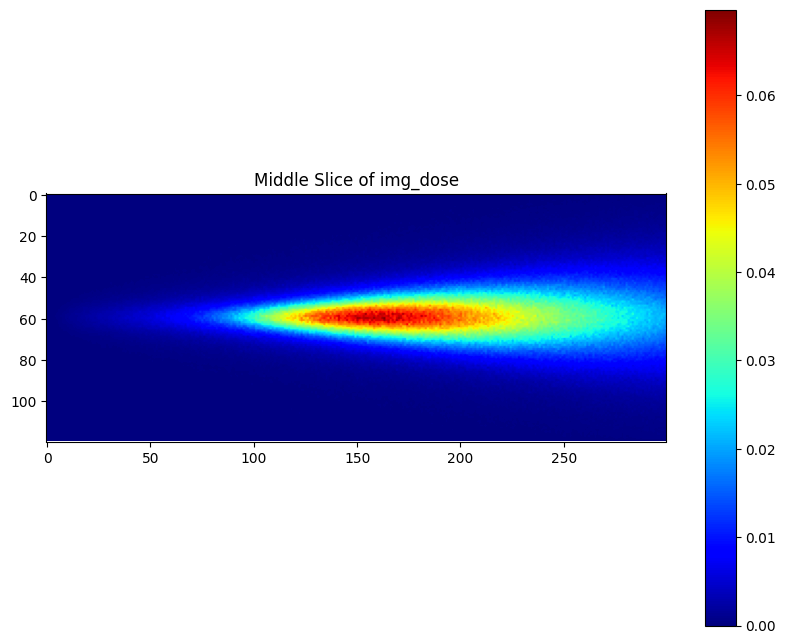

In [ ]:
# Display the middle slice of the img_dose image
arr_dose_mid= arr_dose[:, 50, :]
arr_dose_mid = np.moveaxis(arr_dose_mid, 0, -1)
arr_dose_mid = arr_dose_mid[0:,:]

# Plot the slice
plt.figure(figsize=(10, 8))
plt.imshow(arr_dose_mid, cmap='jet')
plt.title('Middle Slice of img_dose')
plt.colorbar()
plt.show()




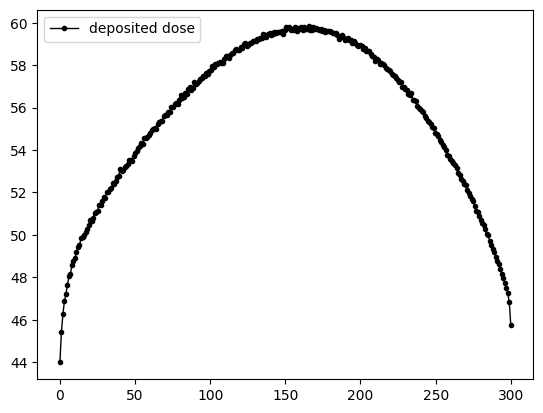

In [ ]:
# Declare a figure
fig3, ax3 = plt.subplots()

# mean the dose along a given dimension (depth)
moy_dose=np.zeros(arr_dose.shape[0])
for i in range(arr_dose.shape[0]):
    subarr_dose=arr_dose[i,:,:]
    moy_dose[i]=np.sum(subarr_dose)

# X values from 0 to n
# n is the number of slices
n = arr_dose.shape[0]
x = np.linspace(0, n, n)

c1 = ax3.plot(x, moy_dose, 'k.-', label='deposited dose', linewidth=1)

# Add legends to the plot
ax3.legend(loc='upper left')


**HITS ANALYSIS**

In [ ]:
f = uproot.open('output/spect.root')
print("List of tree : \n", f.keys())
hits = f['Hits_crystal']
print('Number of hits:', hits.num_entries)
print('Hits keys: ')
for i in hits.keys():
    print(i, ' ', end='')

List of tree : 
 ['Hits_crystal;1']
Number of hits: 2193.0
Hits keys: 
PostPosition_X  PostPosition_Y  PostPosition_Z  PreKineticEnergy  TotalEnergyDeposit  

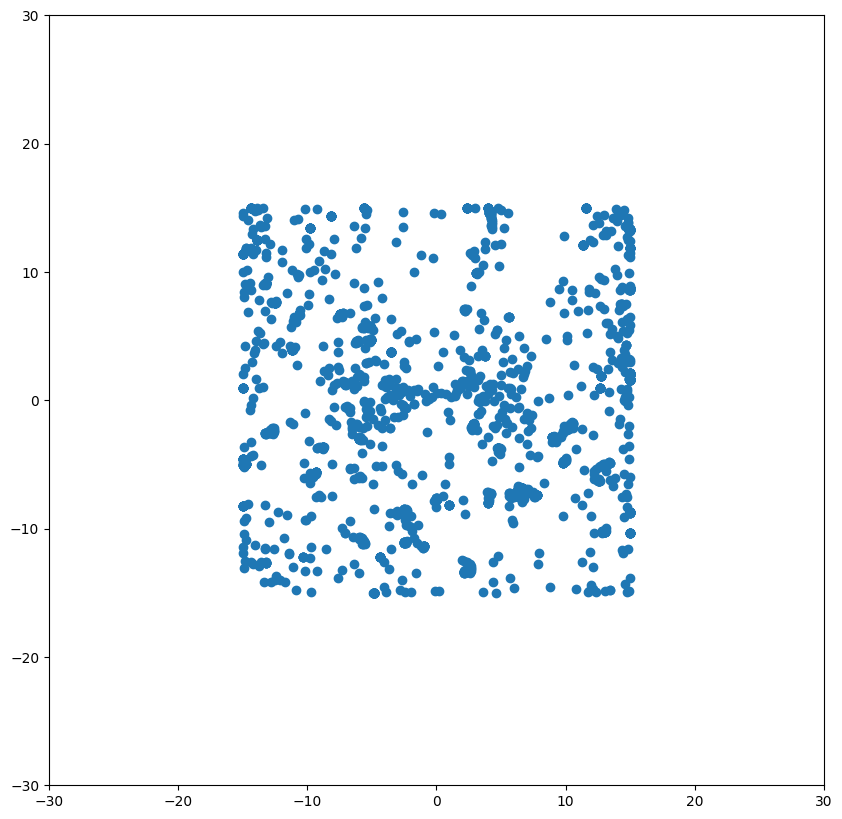

In [ ]:
hits_y = np.array(hits.arrays()['PostPosition_Y'])
hits_z = np.array(hits.arrays()['PostPosition_Z'])
hits_x = np.array(hits.arrays()['PostPosition_X'])
preKinEnergy = np.array(hits.arrays()['PreKineticEnergy'])  

plt.figure(figsize=(10, 10))

plt.scatter(hits_z, hits_y)
plt.xlim(-30, 30)
plt.ylim(-30, 30)

plt.show()

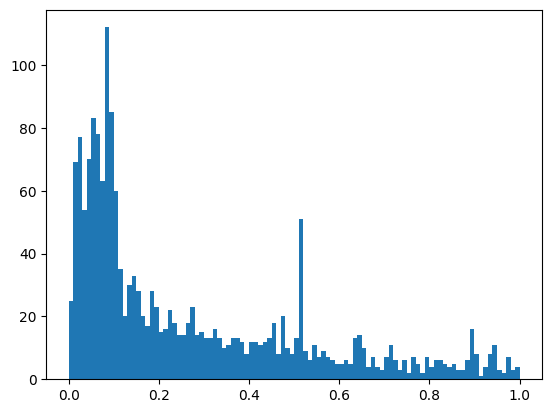

In [ ]:
plt.hist(preKinEnergy, bins=100,range=(0,1))
plt.show()

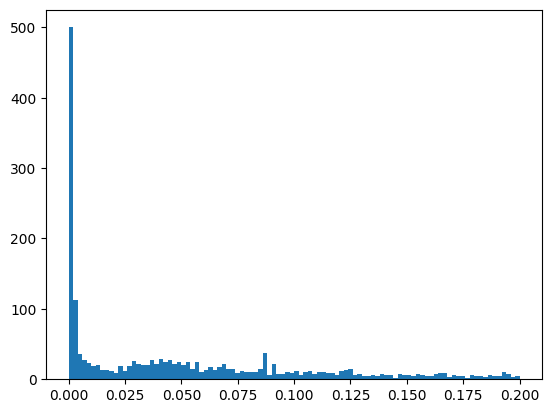

In [ ]:
hits_edep= np.array(hits.arrays()['TotalEnergyDeposit'])

plt.hist(hits_edep, bins=100,range=(0,0.2))
plt.show()
